# Goal

* Create a planning react agent
* Tools
  * `planner`
    * chain-of-thought
  * `critic`
  * `router`

In [1]:
# import 
import os
import operator
from enum import Enum
from pprint import pprint
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any, Sequence, TypedDict
from pydantic import BaseModel, Field
from langchain_core.tools import tool
import pandas as pd
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [2]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

# State

In [25]:
class GraphState(TypedDict):
    """
    Shared state of nodes in the graph
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]
    route: Annotated[str, "route to next node"]

# Tools

## Planner

In [60]:
model_t2 = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
model_t0 = ChatOpenAI(model="gpt-4o", temperature=0)

In [63]:
class Step(BaseModel):
    explanation: str
    output: str

class Planning(BaseModel):
    steps: list[Step]

def invoke_planner(
    state: GraphState
) -> Annotated[dict, "Response from the critic"]:
    """
    The planner tool takes in the current state of the conversation and generates a plan to achieve the goal.
    """
    # create prompt
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You are an expert planner. Think step by step to critique the plan. Concisely explain your reasoning for each step in one or two sentences."),
        # Include all previous messages from the state
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", "Based on the messages above, create a new or revised plan to achieve the goal."),
    ])
    formatted_prompt = prompt.format_messages(
        history=state["messages"][-3:]
    )
    # call the model
    response = model_t2.with_structured_output(Planning, strict=True).invoke(formatted_prompt)
    # format the response
    steps = "\n".join([f" - {x.output}" for x in response.steps])
    return {
        "messages": [AIMessage(content=steps, name="planner")]
    }

state = {"messages" : [
    HumanMessage(content="How do I convert GSE121737 to an SRA accession?", name="human")
]}
# invoke_planner(state)

## Critic

In [64]:
class Reasons(BaseModel):
    explanation: str
    output: str

class Critque(BaseModel):
    critique: str
    reasoning: list[Reasons]

def invoke_critic(
    state: GraphState
) -> Annotated[dict, "Response from the critic"]:
    """
    The critic will help you critique a plan to accomplish a task.
    """
    # create prompt
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You are an expert critic. Think step by step to critique the plan. Concisely explain your reasoning in one or two sentences."),
        # Include all previous messages from the state
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", "Based on the messages above, critique the current plan."
        ),
    ])
    formatted_prompt = prompt.format_messages(
        history=state["messages"][-3:]
    )
    # call the model
    response = model_t2.with_structured_output(Critque, strict=True).invoke(formatted_prompt)
    # format the response
    reasoning = "\n".join([f" - {x.output}" for x in response.reasoning])
    reasoning = f"{response.critique}\nMy reasoning:\n{reasoning}"
    return {
        "messages": [AIMessage(content=reasoning, name="critic")]
    }

# test
state = {"messages" : [
    HumanMessage(content="How do I convert GSE121737 to an SRA accession?", name="human"),
    AIMessage(content="Run Bio.Entrez.esearch ", name="planner"),
]}
# invoke_critic(state)

## Router

In [ ]:
class Choices(Enum):
    CONTINUE = "Continue"
    STOP = "Stop"

class Choice(BaseModel):
    Choice: Choices

def invoke_router(
    state: GraphState
) -> Annotated[dict, "Response from the router"]:
    """
    Route the conversation to the appropriate tool based on the current state of the conversation.
    """
    # create prompt
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You determine whether to continue or stop the conversation."),
        # Include all previous messages from the state
        ("system", "Here is the task:"),
        MessagesPlaceholder(variable_name="task"),
        ("system", "Here are the last few messages:"),
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", "Based on the messages above, select STOP if the task is complete or CONTINUE for another round of planning and critique."),
    ])
    # get the last messages, but it cannot include the first message
    last_n_messages = -6 if len(state["messages"]) > 6 else -(len(state["messages"]) - 1)
    formatted_prompt = prompt.format_messages(
        task=[state["messages"][0].content],
        history=state["messages"][last_n_messages:]
    )
    # call the model
    response = model_t2.with_structured_output(Choice, strict=True).invoke(formatted_prompt)
    return {"route": response.Choice.value}

# test
state = {"messages" : [
    HumanMessage(content="How do I convert GSE121737 to an SRA accession?", name="human"),
    AIMessage(content="Run Bio.Entrez.esearch ", name="planner"),
    AIMessage(content="The plan is good! You can finish", name="critic"),
]}
#invoke_router(state)


# Graph

In [87]:
def route_interpret(state: GraphState) -> str:
    return "planner_node" if state["route"] == "Continue" else END

In [88]:
#-- subgraph --#
workflow = StateGraph(GraphState)

# nodes
workflow.add_node("planner_node", invoke_planner)
workflow.add_node("critic_node", invoke_critic)
workflow.add_node("router_node", invoke_router)

# edges
workflow.add_edge(START, "planner_node")
workflow.add_edge("planner_node", "critic_node")
workflow.add_edge("critic_node", "router_node")
workflow.add_conditional_edges("router_node", route_interpret)

# compile the graph
graph = workflow.compile()

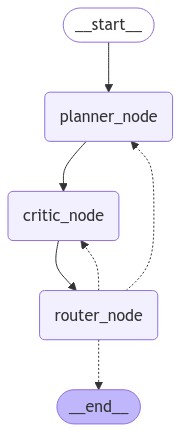

In [89]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [90]:
# Call the graph
final_state = None
input = {"messages" : [
    HumanMessage(content="How do I convert GSE121737 to an SRA accession?", name="human")
]}
for step in graph.stream(input, config={"max_concurrency" : 2, "recursion_limit": 30}):
    print(step)
    final_state = step

{'planner_node': {'messages': [AIMessage(content=' - Access the GEO database and search for GSE121737.\n - Find the SRA accession numbers linked to GSE121737.\n - Review the associated publication for SRA accession information.\n - Utilize GEOquery or similar tools to extract SRA accessions.\n - List and confirm the SRA accession numbers.', additional_kwargs={}, response_metadata={}, name='planner')]}}
{'critic_node': {'messages': [AIMessage(content='The plan provides a clear step-by-step approach to convert GSE121737 to an SRA accession, but it lacks specific details on how to access the GEO database and utilize tools like GEOquery effectively.\nMy reasoning:\n - The critique highlights the need for more detailed instructions to enhance usability.\n - This omission could lead to confusion for users trying to locate the necessary information.', additional_kwargs={}, response_metadata={}, name='critic')]}}
{'router_node': {'route': 'Continue'}}
{'planner_node': {'messages': [AIMessage(c